# PPO

TODO

- Add gradient clipping to the value loss. The value loss is leading to destructively large model updates.

## Imports and hyperparameters

In [201]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

import random
import math
import time

import matplotlib.pyplot as plt

import gymnasium as gym

In [202]:
env = gym.make('CartPole-v1')

N_OBSERVATIONS = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

# Hyperparameters
N_AGENTS = 16
T = 100
GAMMA = 0.99
EPSILON = 0.1
H = 0.5 # Entropy constant
V = 2e-2 # Value constant
LR = 1e-4
BATCH_SIZE = 256
N_EPOCHS = 3
N_TRAIN_LOOPS = 200

TEST = False
TRAIN = True

layer_dim = 128

## Model and selecting actions

### Model

I'll use the same parameters for the policy and value networks. If this doesn't work well I can change it later.

In [203]:
class PolicyAndValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(N_OBSERVATIONS, layer_dim),
            nn.ReLU(),
            nn.Linear(layer_dim, layer_dim),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(layer_dim, N_ACTIONS)
        self.value_head = nn.Linear(layer_dim, 1)

    def forward(self, x):
        shared_output = self.shared_layers(x)
        action_logits = self.policy_head(shared_output)
        value = self.value_head(shared_output)
        return torch.cat([action_logits, value], dim=-1)

### Select action

Select action based on log probabilities.

In [204]:
def select_action(action_logits):
    action_probs = torch.softmax(action_logits, dim=0)
    action = torch.multinomial(action_probs, num_samples=1).item()
    return action

### Test

In [205]:
if TEST:
    test_env = gym.make('CartPole-v1', render_mode='human')
    test_model = PolicyAndValueNetwork()

    for _ in range(1):
        state, info = test_env.reset()
        terminated, truncated = False, False
        while not (terminated or truncated):
            tensor_state = torch.from_numpy(state)
            logits = test_model(tensor_state)
            action_logits = logits[:-1]
            action = select_action(action_logits)
            state, reward, terminated, truncated, info = test_env.step(action)

    test_env.close()

## Data

### Data collector

We first collect the data while marking episode ends when they happen.

In [206]:
class DataCollector():
    def __init__(self):
        self.states = [[] for _ in range(N_AGENTS)]
        self.actions = [[] for _ in range(N_AGENTS)]
        self.rewards = [[] for _ in range(N_AGENTS)]
        self.pis = [[] for _ in range(N_AGENTS)]
        self.episode_ends = [[] for _ in range(N_AGENTS)]

    def add_step(self, agent_id, state, action, reward, pi):
        self.states[agent_id].append(state)
        self.actions[agent_id].append(action)
        self.rewards[agent_id].append(reward)
        self.pis[agent_id].append(pi)

    def mark_episode_end(self, agent_id, timestep):
        self.episode_ends[agent_id].append(timestep)

    def fetch_data(self):
        list_of_agent_states = [torch.stack(agent_states) for agent_states in self.states]
        states = torch.stack([agent_states for agent_states in list_of_agent_states])
        actions = self.actions
        rewards = torch.tensor(self.rewards)
        pis = torch.tensor(self.pis)
        episode_ends = self.episode_ends

        return states, actions, rewards, pis, episode_ends

### Compute advantages and target values

Next we'll need to compute advantages and target values. We'll start from the end of the data for each agent and move backwards. This makes the desired values easier to compute and to take into account episode ends.

Gradients should be on here because I'll use the computations here to optimize the model.

> If the trajectory terminated due to the maximal trajectory length T
being reached, Vωold (st+n ) denotes the state value associated with state st+n as predicted by the state value
network. Otherwise, Vωold (st+n ) is set to 0

Instead of computing r_t + V(s_t+1) I'm using V(s_t). It's similar enough and shouldn't be that much of a problem.

In [207]:
def compute_advantages_and_target_values(model, states, rewards, episode_ends):
    # We'll add them from last to first, then reverse list
    reversed_target_values = [[] for _ in range(N_AGENTS)]
    reversed_advantages = [[] for _ in range(N_AGENTS)]

    with torch.no_grad():
        for agent in range(N_AGENTS):
            for i in range(T):
                # Get step state and reward and compute predicted value
                state = states[agent, -i-1]
                reward = rewards[agent, -i-1]
                predicted_value = model(state)[-1]

                # If step is final
                if i in episode_ends[agent]:
                    target_value = reward
                # If step is last but not final
                elif i == 0:
                    target_value = predicted_value
                # non-last non-final step
                else:
                    # Get previous target value and compute 
                    previous_target_value = reversed_target_values[agent][-1]
                    target_value = reward + GAMMA * previous_target_value
                advantage = target_value - predicted_value

                # Append target value and advantage
                reversed_target_values[agent].append(target_value)
                reversed_advantages[agent].append(advantage)

    target_values = [torch.stack(agent_target_values[::-1]) for agent_target_values in reversed_target_values]
    advantages = [torch.stack(agent_advantage[::-1]) for agent_advantage in reversed_advantages]

    return target_values, advantages

### PPO training data

I need to modify the data so that I can sample random batches from it.

In [208]:
class PPODataset(Dataset):
    def __init__(self, states, actions, pis, target_values, advantages):
        # Reshape all into (N_AGENTS * T, whatever (possibly 0))
        self.states = states.reshape(N_AGENTS * T, -1)
        self.actions = [action for agent in actions for action in agent]
        self.pis = pis.reshape(N_AGENTS * T)
        self.target_values = torch.cat(target_values)
        self.advantages = torch.cat(advantages)
        
    def __len__(self):
        return len(self.actions)
    
    def __getitem__(self, i):
        state = self.states[i]
        action = self.actions[i]
        pi = self.pis[i]
        target_value = self.target_values[i]
        advantage = self.advantages[i]

        return state, action, pi, target_value, advantage

## Training

### Loss function(s)

We have a 3-in-1 loss function. We want to minimize

- -L_CLIP  + V * L_V - H * L_H

I'll write each of the separate functions then combine them in one that will be backpropagated.

In [209]:
def clipped_objective_fn(log_probs, pi_batch, action_batch, advantage_batch):
    # Compute pi_new
    pi_new = log_probs[torch.arange(len(action_batch)), action_batch]

    # Compute p_ratio, ratio of new and old probabilities
    # note that it's unnormalized
    p_ratio = torch.exp(pi_new - pi_batch)

    # Compute unclipped and clipped surrogate objectives
    unclipped_surrogate_objective = p_ratio * advantage_batch
    clipped_surrogate_objective = torch.clamp(p_ratio, 1. - EPSILON, 1. + EPSILON) * advantage_batch

    # Compute elementwise minimum of two and return
    clipped_objective = torch.mean(torch.min(unclipped_surrogate_objective, clipped_surrogate_objective))
    return clipped_objective

In [210]:
def entropy_bonus_fn(log_probs):
    # Compute probabilities
    probs = torch.softmax(log_probs, dim=-1)

    # Compute and return entropy
    entropy = -torch.mean(torch.sum(probs * log_probs, dim=-1))
    return entropy

In [211]:
def value_loss_fn(pred_values, target_value_batch):
    # Compute and return loss
    mseloss = nn.MSELoss(reduction='mean')
    loss = mseloss(pred_values, target_value_batch)
    return loss

In [212]:
def loss_fn(model, state_batch, action_batch, pi_batch, target_value_batch, advantage_batch):
    # Get pred log probs and values
    output = model(state_batch)
    log_probs, pred_values = torch.log_softmax(output[:, :-1], dim=-1), output[:, -1]

    # Compute individual losses
    clipped_objective = clipped_objective_fn(log_probs, pi_batch, action_batch, advantage_batch)
    value_loss = value_loss_fn(pred_values, target_value_batch)
    entropy_bonus = entropy_bonus_fn(log_probs)

    # Compute and return total loss
    loss = -clipped_objective + V * value_loss - H * entropy_bonus
    return loss, clipped_objective.item(), V * value_loss.item(), H * entropy_bonus.item()

### Train loop

In [213]:
model = PolicyAndValueNetwork()
optimizer = optim.Adam([
    {'params': model.shared_layers.parameters(), 'lr': LR},
    {'params': model.policy_head.parameters(), 'lr': LR},
    {'params': model.value_head.parameters(), 'lr': LR * 1e-1}
])

In [214]:
def train_loop(model, loss_fn, optimizer):
    avg_rewards = []
    avg_losses = []
    avg_clipped_objectives = []
    avg_value_losses = []
    avg_entropy_bonuses = []
    for i in range(N_TRAIN_LOOPS):
        print(f"Train loop {i+1}-----------")
        data_collector = DataCollector()

        # Initilize all environments
        envs = [[gym.make('CartPole-v1')] for _ in range(N_AGENTS)]
        for agent_env in envs:
            state, _ = agent_env[0].reset()
            terminated, truncated = False, False
            agent_env += [state, terminated, truncated]

        with torch.no_grad():
            for agent in range(N_AGENTS):
                env = envs[agent][0]
                state, terminated, truncated = envs[agent][1:]

                for step in range(T):
                    # Compute and divide model output
                    state = torch.from_numpy(state)
                    output = model(state)
                    action_logits = output[:-1]

                    # Select and perform action
                    action = select_action(action_logits)
                    next_state, reward, terminated, truncated, _ = env.step(action)

                    # Compute pi
                    pi = torch.log_softmax(action_logits, dim=-1)[action]

                    # Store data
                    data_collector.add_step(agent, state, action, reward, pi)

                    # If terminated reset env and mark end, otherwise update state
                    if terminated or truncated:
                        data_collector.mark_episode_end(agent, step)
                        state, _ = env.reset()
                        terminated, truncated = False, False
                    else:
                        state = next_state

        # Fetch data from data collector
        states, actions, rewards, pis, episode_ends = data_collector.fetch_data()

        # Compute advantages and target values
        target_values, advantages = compute_advantages_and_target_values(
            model=model,
            states=states,
            rewards=rewards,
            episode_ends=episode_ends,
        )

        # Add everything to dataset and create dataloader
        dataset = PPODataset(states, actions, pis, target_values, advantages)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=BATCH_SIZE,
            shuffle=True
        )

        # Train model on policy for N_EPOCHS
        total_loss = 0.
        total_clipped_objective = 0.
        total_value_loss = 0.
        total_entropy_bonus = 0.
        for _ in range(N_EPOCHS):
            for state_batch, action_batch, pi_batch, target_value_batch, advantage_batch in dataloader:
                # Compute loss and optimize
                loss, clipped_objective, value_loss, entropy_bonus = loss_fn(
                    model,
                    state_batch,
                    action_batch,
                    pi_batch,
                    target_value_batch,
                    advantage_batch
                )
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # Add losses
                total_loss += loss.item()
                total_clipped_objective += clipped_objective
                total_value_loss += value_loss
                total_entropy_bonus += entropy_bonus

        # Compute averages and add them to lists
        n_iterations = N_EPOCHS * ((N_AGENTS * T) // BATCH_SIZE)
        avg_loss = total_loss / n_iterations
        avg_clipped_objective = total_clipped_objective / n_iterations
        avg_value_loss = total_value_loss / n_iterations
        avg_entropy_bonus = total_entropy_bonus / n_iterations

        # Print average losses
        print(f"avg total loss: {avg_loss:.4f}")

        # Append to lists for later plotting or analysis
        avg_losses.append(avg_loss)
        avg_clipped_objectives.append(avg_clipped_objective)
        avg_value_losses.append(avg_value_loss)
        avg_entropy_bonuses.append(avg_entropy_bonus)

        # Test model returning average reward
        with torch.no_grad():
            test_env = gym.make('CartPole-v1')
            total_reward = 0
            for _ in range(10):
                state, _ = test_env.reset()
                terminated, truncated = False, False
                while not (terminated or truncated):
                    total_reward += 1
                    tensor_state = torch.from_numpy(state)
                    logits = model(tensor_state)
                    action_logits = logits[:-1]
                    action = select_action(action_logits)
                    state, reward, terminated, truncated, _ = test_env.step(action)
            avg_reward = total_reward / 10
            print(f"avg reward: {avg_reward}")
            avg_rewards.append(avg_reward)
            test_env.close()

    return avg_rewards, avg_losses, avg_clipped_objectives, avg_value_losses, avg_entropy_bonuses

In [219]:
if TRAIN:
    avg_rewards, avg_losses, avg_clipped_objectives, avg_value_losses, avg_entropy_bonuses = train_loop(model, loss_fn, optimizer)

Train loop 1-----------
avg total loss: -0.2590
avg reward: 94.6
Train loop 2-----------
avg total loss: -8.1589
avg reward: 129.1
Train loop 3-----------
avg total loss: 5.8790
avg reward: 142.4
Train loop 4-----------
avg total loss: -6.6947
avg reward: 149.9
Train loop 5-----------
avg total loss: 8.2150
avg reward: 125.2
Train loop 6-----------
avg total loss: -1.5332
avg reward: 106.2
Train loop 7-----------
avg total loss: 6.3553
avg reward: 87.5
Train loop 8-----------
avg total loss: 6.3295
avg reward: 120.3
Train loop 9-----------
avg total loss: 19.4292
avg reward: 106.9
Train loop 10-----------
avg total loss: -7.2350
avg reward: 117.1
Train loop 11-----------
avg total loss: -4.6213
avg reward: 112.4
Train loop 12-----------
avg total loss: -5.7334
avg reward: 117.8
Train loop 13-----------
avg total loss: 10.4696
avg reward: 96.9
Train loop 14-----------
avg total loss: 7.8371
avg reward: 142.1
Train loop 15-----------
avg total loss: 11.4163
avg reward: 124.1
Train loop 1

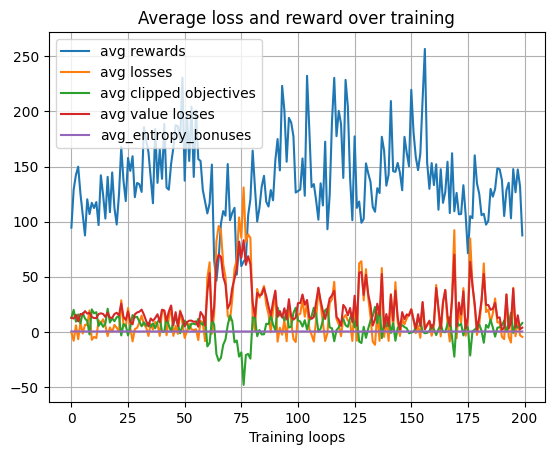

In [220]:
plt.plot(avg_rewards, label="avg rewards")
plt.plot(avg_losses, label="avg losses")
plt.plot(avg_clipped_objectives, label="avg clipped objectives")
plt.plot(avg_value_losses, label="avg value losses")
plt.plot(avg_entropy_bonuses, label="avg_entropy_bonuses")
plt.title("Average loss and reward over training")
plt.xlabel("Training loops")
plt.legend()
plt.grid(True)
plt.show()

In [222]:
test_env = gym.make('CartPole-v1', render_mode='human')
test_model = model

for _ in range(3):
    state, info = test_env.reset()
    terminated, truncated = False, False
    while not (terminated or truncated):
        tensor_state = torch.from_numpy(state)
        logits = test_model(tensor_state)
        action_logits = logits[:-1]
        action = select_action(action_logits)
        state, reward, terminated, truncated, info = test_env.step(action)

test_env.close()